# N$_2$ prototype - energy & rdm1

In [1]:
import pyscf
from pyscf import gto, scf, dft, ao2mo, fci, mcscf
from pyscf.mrpt.nevpt2 import NEVPT
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt

In [2]:
HARTREE_TO_eV = 27.311285

In [3]:
1.0/(0.3166808991e-5*27.311285)

11562.0807045062

In [4]:
npoints = 20
R_begin=1.0
R_end=3.5
R = np.linspace(start=R_begin,stop=R_end,num=npoints)

In [64]:
def get_entropy(mf,mo_occ=None):
    if mo_occ is None:
        f = mf.get_occ()/2
    else:
        f = mo_occ /2
    #print(f)
    f = f[(f>0) & (f<1)]
    return -2*(f*np.log(f) + (1-f)*np.log(1-f)).sum()

In [6]:
def run_rks(mol_str,smear=False,tau=500,basis='cc-pVTZ', verbose=0):
    mol = gto.M(atom=mol_str, basis=basis)
    mol.smearing = smear
    mol.tau = tau
    mf = scf.RKS(mol)
    mf.xc='PBE'
    mf.run()
    h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
    rdm1=mf.make_rdm1()
    T = mf.mol.intor_symmetric('int1e_kin')
    Ekin = np.einsum('pq,qp', T, rdm1)*HARTREE_TO_eV
    #print("Ts: ", Ekin)
    #d = np.zeros(h1.shape[0])
    s = mf.get_occ()
    #for i in np.arange(h1.shape[0]):
    #    d[i] = h1[i,i]
    return s, mf, Ekin, mf.energy_tot()*HARTREE_TO_eV

In [7]:
def run_fci(mol_str,basis='cc-pVTZ', verbose=0):
    mol = gto.M(atom=mol_str, basis=basis)
    mf = scf.RHF(mol)
    mf.run()
    mc = pyscf.mcscf.CASSCF(mf, 10, 10)
    e_casscf = mc.kernel()[0]
    e_nevpt2 = NEVPT(mc).kernel()
    e = e_casscf + e_nevpt2
    from pyscf.mcscf.addons import make_rdm1
    rdm1 = make_rdm1(mc)
    norb=np.shape(mf.get_occ())[0]
    T = mf.mol.intor_symmetric('int1e_kin')
    Ekin = np.einsum('pq,qp', T, rdm1)*HARTREE_TO_eV
    s = np.zeros(norb)
    for i in np.arange(norb):
        occ = mc.mo_coeff.T.dot(rdm1).dot(mc.mo_coeff)
        s[i] = occ[i,i]
    return s, mf, Ekin, e*HARTREE_TO_eV


In [55]:
def run_casci(mol_str,basis='cc-pVTZ', verbose=0):
    mol = gto.M(atom=mol_str, basis=basis)
    mf = scf.RHF(mol)
    mf.run()
    mc = pyscf.mcscf.CASCI(mf, 10, 10)
    e_casscf = mc.kernel()[0]
    e_nevpt2 = NEVPT(mc).kernel()
    e = e_casscf + e_nevpt2
    from pyscf.mcscf.addons import make_rdm1
    rdm1 = make_rdm1(mc)
    norb=np.shape(mf.get_occ())[0]
    T = mf.mol.intor_symmetric('int1e_kin')
    Ekin = np.einsum('pq,qp', T, rdm1)*HARTREE_TO_eV
    s = lin.eigh(rdm1, mf.get_ovlp(), type=2)[0]
    #s = np.zeros(norb)
    #for i in np.arange(norb):
    #    s[i] = occ[i,i]
    return s, mf, Ekin, e*HARTREE_TO_eV


In [9]:
smear = False
occupations_KS = []
energies_KS = []
calculations_KS = []
Ekin_KS = []
ener_KS = []
for i in np.arange(npoints):
    mol_str = "N 0 0 0; N 0 0 "+str(R[i])
    s, mf, Ekin, e = run_rks(mol_str=mol_str, smear=smear)
    occupations_KS.append(s)
    calculations_KS.append(mf)
    Ekin_KS.append(Ekin)
    ener_KS.append(e)

converged SCF energy = -109.410858772288
converged SCF energy = -109.444986388651
converged SCF energy = -109.400610740196
converged SCF energy = -109.330315779524
converged SCF energy = -109.256886210295
converged SCF energy = -109.18902339803
converged SCF energy = -109.129342479703
converged SCF energy = -109.078128831207
converged SCF energy = -109.034817479261
converged SCF energy = -108.998529541546
converged SCF energy = -108.968309891081
converged SCF energy = -108.943242184024
converged SCF energy = -108.922514056408
converged SCF energy = -108.905427734112
converged SCF energy = -108.891369436697
converged SCF energy = -108.879811983019
converged SCF energy = -108.870315878871
converged SCF energy = -108.862514178842
converged SCF energy = -108.856101572799
converged SCF energy = -108.850827297281


In [10]:
tau = 11562.0807045062 #KT=1eV
smear = True
occupations_KS_tau = []
energies_KS_tau = []
calculations_KS_tau = []
Ekin_KS_tau = []
ener_KS_tau = []

for i in np.arange(npoints):
    mol_str = "N 0 0 0; N 0 0 "+str(R[i])
    s, mf, Ekin, e = run_rks(mol_str=mol_str,tau=tau,smear=smear)
    occupations_KS_tau.append(s)
    calculations_KS_tau.append(mf)
    if smear:
        mTS=-0.3166808991e-5*tau*get_entropy(mf)*HARTREE_TO_eV
    else:
        mTS = 0.0
    print(mTS)
    Ekin_KS_tau.append(Ekin)
    ener_KS_tau.append(e+mTS)

converged SCF energy = -109.401766987715
-0.2966410802613013
converged SCF energy = -109.424273692182
-0.7007976596824008
converged SCF energy = -109.360862901503
-1.412957050870645
converged SCF energy = -109.26772827914
-2.382424814341697
converged SCF energy = -109.174650124339
-3.423551952315871
converged SCF energy = -109.094819753758
-4.3697471941727875
converged SCF energy = -109.030318369944
-5.1753489987211605
converged SCF energy = -108.978719307331
-5.868581923476819
converged SCF energy = -108.937793723578
-6.467222001538728
converged SCF energy = -108.906251770407
-6.964012527487629
converged SCF energy = -108.882826542023
-7.353750005932903
converged SCF energy = -108.865974313165
-7.6449906286314375
converged SCF energy = -108.854132456417
-7.8549467559484905
converged SCF energy = -108.845950130621
-8.002518059800298
converged SCF energy = -108.84034787523
-8.104448116502432
converged SCF energy = -108.836521697167
-8.174057718351335
converged SCF energy = -108.83390596

In [56]:
occupations_FCI = []
energies_FCI = []
calculations_FCI = []
Ekin_FCI = []
ener_FCI = []
for i in np.arange(npoints):
    mol_str = "N 0 0 0; N 0 0 "+str(R[i])
    s, mf, Ekin, e = run_casci(mol_str=mol_str)
    occupations_FCI.append(s)
    calculations_FCI.append(mf)
    Ekin_FCI.append(Ekin)
    ener_FCI.append(e)

converged SCF energy = -108.96801501192
CASCI E = -109.025445640972  E(CI) = -32.787928558771  S^2 = 0.0000000
Sr    (-1)',   E = -0.10985504883989
Si    (+1)',   E = -0.00010237207745
Sijrs (0)  ,   E = -0.01369698175575
Sijr  (+1) ,   E = -0.00069076874609
Srsi  (-1) ,   E = -0.01098709406769
Srs   (-2) ,   E = -0.15588458027295
Sij   (+2) ,   E = -0.00002089200646
Sir   (0)' ,   E = -0.00189546352175
Nevpt2 Energy = -0.293133201288036
converged SCF energy = -108.973814946896
CASCI E = -109.056695553163  E(CI) = -31.2808965988287  S^2 = 0.0000000
Sr    (-1)',   E = -0.11784490422756
Si    (+1)',   E = -0.00010002896143
Sijrs (0)  ,   E = -0.01233711564399
Sijr  (+1) ,   E = -0.00077214244846
Srsi  (-1) ,   E = -0.00993050377490
Srs   (-2) ,   E = -0.14967742676819
Sij   (+2) ,   E = -0.00001850921591
Sir   (0)' ,   E = -0.00194135476163
Nevpt2 Energy = -0.292621985802066
converged SCF energy = -108.896625591608
CASCI E = -109.01208442874  E(CI) = -30.0183253294946  S^2 = 0.0000000
Sr

Sijr  (+1) ,   E = -0.00086818065909
Srsi  (-1) ,   E = -0.00753878865862
Srs   (-2) ,   E = -0.09226047356896
Sij   (+2) ,   E = -0.00002206311630
Sir   (0)' ,   E = -0.00290908840936
Nevpt2 Energy = -0.229706832773361
converged SCF energy = -107.951122068049
CASCI E = -108.767339126895  E(CI) = -23.0804853591509  S^2 = 5.8699323
Sr    (-1)',   E = -0.11686447889848
Si    (+1)',   E = -0.00009239127437
Sijrs (0)  ,   E = -0.00882018365868
Sijr  (+1) ,   E = -0.00084475589832
Srsi  (-1) ,   E = -0.00755188250610
Srs   (-2) ,   E = -0.09271092971481
Sij   (+2) ,   E = -0.00002159781881
Sir   (0)' ,   E = -0.00289593989610
Nevpt2 Energy = -0.229802159665667


In [ ]:
occupations_FCI = []
energies_FCI = []
calculations_FCI = []
Ekin_FCI = []
ener_FCI = []
for i in np.arange(npoints):
    mol_str = "N 0 0 0; N 0 0 "+str(R[i])
    s, mf, Ekin, e = run_fci(mol_str=mol_str)
    occupations_FCI.append(s)
    calculations_FCI.append(mf)
    Ekin_FCI.append(Ekin)
    ener_FCI.append(e)

In [59]:
occupations_FCI = np.array(occupations_FCI,dtype=np.float)
occupations_KS = np.array(occupations_KS,dtype=np.float)
occupations_KS_tau = np.array(occupations_KS_tau,dtype=np.float)

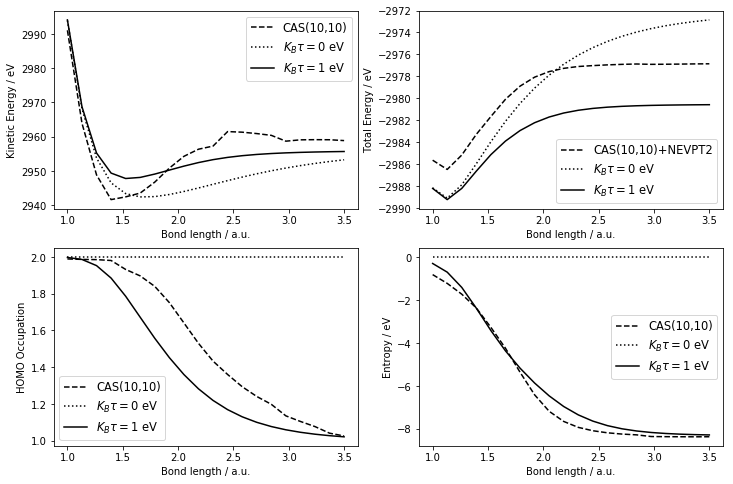

In [65]:
font=11.5
fig, ax = plt.subplots(2,2,figsize=(12,8))
#
ax[0,0].set_ylabel("Kinetic Energy / eV")
ax[0,0].plot(R,Ekin_FCI,label=r'CAS(10,10)',color='black',linestyle='--')
ax[0,0].plot(R,Ekin_KS,label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[0,0].plot(R,Ekin_KS_tau,label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')
#
ax[0,1].set_ylabel("Total Energy / eV")
ax[0,1].plot(R,ener_FCI,label=r'CAS(10,10)+NEVPT2',color='black',linestyle='--')
ax[0,1].plot(R,ener_KS,label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[0,1].plot(R,ener_KS_tau,label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')
#
ax[1,0].set_ylabel("HOMO Occupation")
ax[1,0].plot(R,occupations_FCI[:,-5],label=r'CAS(10,10)',color='black',linestyle='--')
ax[1,0].plot(R,occupations_KS[:,5],label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[1,0].plot(R,occupations_KS_tau[:,5],label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')
#ax[1,0].set_ylim([0,2])
#
ax[1,1].set_ylabel("Entropy / eV")
entropy_KS = np.zeros(npoints)
entropy_KS_tau = np.zeros(npoints)
entropy_FCI = np.zeros(npoints)
for i in range(npoints):
    #entropy_KS[i]=-0.3166808991e-5*tau*get_entropy(calculations_KS_tau[i])
    entropy_KS_tau[i]=-0.3166808991e-5*tau*get_entropy(calculations_KS_tau[i])*HARTREE_TO_eV
    entropy_FCI[i]=-0.3166808991e-5*tau*get_entropy(calculations_FCI[i],occupations_FCI[i,:])*HARTREE_TO_eV

ax[1,1].plot(R,entropy_FCI,label=r'CAS(10,10)',color='black',linestyle='--')
ax[1,1].plot(R,entropy_KS,label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[1,1].plot(R,entropy_KS_tau,label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')

#ax[0,0].legend(fontsize=font)
for i in 0, 1:
    for j in 0, 1:
        ax[i,j].legend(fontsize=font)
        ax[i,j].set_xlabel("Bond length / a.u.")
plt.savefig("N2_CAS.pdf")
plt.show()